In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import col

# Crear sesión Spark
spark = SparkSession.builder \
    .appName("SECOP_CrossValidation") \
    .master("spark://spark-master:7077") \
    .getOrCreate()

# Cargar datos procesados
df = spark.read.parquet("/opt/spark-data/raw/secop_ml_ready.parquet")

# Ajustar nombres de columnas para ML
df = df.withColumnRenamed("valor_del_contrato_log", "label") \
       .withColumnRenamed("features_pca", "features") \
       .filter(col("label").isNotNull())

# Train / Test split
train, test = df.randomSplit([0.8, 0.2], seed=42)

print(f"Train: {train.count():,}")
print(f"Test: {test.count():,}")


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/14 05:40:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Train: 80,068
Test: 19,932


26/02/14 05:41:02 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


### **Entender concepto de K-Fold**

**Pregunta conceptual**: Si usas K=5, responde:

**¿En cuantos subconjuntos se dividen los datos de train?**

En k subconjunto, si K=5, el dataset de entrenamiento se divide en 5 folds.

**¿Cuántos modelos se entrenan en total?**  

Se entrenan K modelos por cada combinación de hiperparámetros. Si K=5, se entrenan 5 modelos por configuracion.

**¿Qué porcentaje de datos se usa para validación en cada iteración?**  
   
1/K del dataset de entrenamiento. Si K=5 → 20% se usa para validación en cada iteración.

**¿Qué métrica se reporta al final?**  

Se reporta el promedio de la métrica (por ejemplo RMSE) sobre los K folds.


### ¿Por qué es mejor que un simple train/test split?

- Reduce la varianza en la estimación del error.
- No depende de un único split.
- Usa todo el dataset de entrenamiento tanto para entrenar como para validar.
- Proporciona una estimación más robusta del desempeño real del modelo.


| Iteración | Fold 1 | Fold 2 | Fold 3 | Fold 4 | Fold 5 |
|-----------|--------|--------|--------|--------|--------|
| 1         | VAL    | Train  | Train  | Train  | Train  |
| 2         | Train  | VAL    | Train  | Train  | Train  |
| 3         | Train  | Train  | VAL    | Train  | Train  |
| 4         | Train  | Train  | Train  | VAL    | Train  |
| 5         | Train  | Train  | Train  | Train  | VAL    |

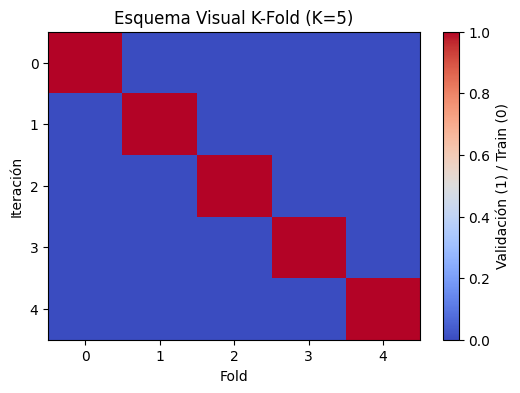

In [2]:
import matplotlib.pyplot as plt
import numpy as np

K = 5
data = np.eye(K)

plt.figure(figsize=(6, 4))
plt.imshow(data, cmap="coolwarm", aspect="auto")
plt.title("Esquema Visual K-Fold (K=5)")
plt.xlabel("Fold")
plt.ylabel("Iteración")
plt.colorbar(label="Validación (1) / Train (0)")
plt.xticks(range(K))
plt.yticks(range(K))
plt.show()


### **Crear modelo base y evaluador**

Para el modelo base utilizamos **LinearRegression** sin fijar hiperparámetros de regularización. 
Esto permite que el proceso de Cross-Validation explore diferentes valores de `regParam` y `elasticNetParam` posteriormente.

**Métrica elegida: RMSE**

Se utiliza **RMSE (Root Mean Squared Error)** porque:

- Penaliza más los errores grandes.
- Está en la misma escala monetaria del contrato.
- Es estándar en problemas de regresión económica.
- Permite comparar directamente magnitud de error en pesos.

Podría usarse también:
- **MAE** → menos sensible a outliers.
- **R²** → mide proporción de varianza explicada.

Sin embargo, RMSE es más apropiado en este contexto porque los valores contractuales presentan alta dispersión.


In [3]:
# Modelo base (sin regularización fija)
lr = LinearRegression(
    featuresCol="features",
    labelCol="label",
    maxIter=100
)

# Evaluador
evaluator = RegressionEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="rmse"
)

print("Modelo base y evaluador configurados correctamente")


Modelo base y evaluador configurados correctamente


### **Construir ParamGrid de hiperparametros**

En este paso definimos la grilla de hiperparámetros que serán evaluados mediante Cross-Validation.

Se explorarán combinaciones de:

- regParam (λ): controla la fuerza de regularización
- elasticNetParam (α): define el tipo de regularización
  - 0.0 → Ridge (L2)
  - 0.5 → ElasticNet
  - 1.0 → Lasso (L1)

### Número de combinaciones

Si usamos:
- 3 valores de regParam
- 3 valores de elasticNetParam

Entonces combinaciones = 3 × 3 = 9

Y para nosotros quedaria:

In [4]:
# Definir valores de hiperparámetros
reg_values = [0.01, 0.1, 1.0]       # λ
elastic_values = [0.0, 0.5, 1.0]    # α

# Construir ParamGrid

param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr.maxIter, [50, 100]) \
    .addGrid(lr.fitIntercept, [True, False]) \
    .build()

print(f"Combinaciones totales: {len(param_grid)}")

# Suponiendo K=5
K = 5
print(f"Total de modelos a entrenar: {len(param_grid) * K}")


Combinaciones totales: 36
Total de modelos a entrenar: 180


### **Configurar CrossValidator (elegir K)**

In [5]:
# Elegimos K=5
K = 5

crossval = CrossValidator(
    estimator=lr,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=K,
    seed=42
)

print(f"✓ Cross-Validation configurado con K={K} folds")
print(f"Combinaciones en grid: {len(param_grid)}")
print(f"Total modelos a entrenar: {len(param_grid) * K}")


✓ Cross-Validation configurado con K=5 folds
Combinaciones en grid: 36
Total modelos a entrenar: 180


In [6]:
print("Entrenando con Cross-Validation...")
cv_model = crossval.fit(train)
print("✓ Cross-validation completada")


Entrenando con Cross-Validation...


26/02/14 05:53:11 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
26/02/14 05:53:11 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
26/02/14 05:53:11 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


✓ Cross-validation completada


In [7]:
avg_metrics = cv_model.avgMetrics
best_metric_idx = avg_metrics.index(min(avg_metrics))

print("\n=== MÉTRICAS PROMEDIO POR CONFIGURACIÓN ===")

for i, metric in enumerate(avg_metrics):
    params = param_grid[i]
    reg = params.get(lr.regParam)
    elastic = params.get(lr.elasticNetParam)
    marker = " <-- MEJOR" if i == best_metric_idx else ""
    print(f"Config {i+1}: λ={reg:.2f}, α={elastic:.1f} -> RMSE={metric:,.2f}{marker}")

# Obtener mejor modelo y evaluarlo en Test

best_model = cv_model.bestModel

print("\n=== MEJOR MODELO ===")
print(f"regParam: {best_model.getRegParam()}")
print(f"elasticNetParam: {best_model.getElasticNetParam()}")

predictions = best_model.transform(test)
rmse_test = evaluator.evaluate(predictions)

print(f"RMSE en Test: ${rmse_test:,.2f}")




=== MÉTRICAS PROMEDIO POR CONFIGURACIÓN ===
Config 1: λ=0.01, α=0.0 -> RMSE=0.95 <-- MEJOR
Config 2: λ=0.01, α=0.0 -> RMSE=1.86
Config 3: λ=0.01, α=0.0 -> RMSE=0.95
Config 4: λ=0.01, α=0.0 -> RMSE=1.86
Config 5: λ=0.01, α=0.5 -> RMSE=0.95
Config 6: λ=0.01, α=0.5 -> RMSE=1.86
Config 7: λ=0.01, α=0.5 -> RMSE=0.95
Config 8: λ=0.01, α=0.5 -> RMSE=1.86
Config 9: λ=0.01, α=1.0 -> RMSE=0.95
Config 10: λ=0.01, α=1.0 -> RMSE=1.86
Config 11: λ=0.01, α=1.0 -> RMSE=0.95
Config 12: λ=0.01, α=1.0 -> RMSE=1.86
Config 13: λ=0.10, α=0.0 -> RMSE=0.95
Config 14: λ=0.10, α=0.0 -> RMSE=1.86
Config 15: λ=0.10, α=0.0 -> RMSE=0.95
Config 16: λ=0.10, α=0.0 -> RMSE=1.86
Config 17: λ=0.10, α=0.5 -> RMSE=0.97
Config 18: λ=0.10, α=0.5 -> RMSE=1.87
Config 19: λ=0.10, α=0.5 -> RMSE=0.97
Config 20: λ=0.10, α=0.5 -> RMSE=1.87
Config 21: λ=0.10, α=1.0 -> RMSE=0.99
Config 22: λ=0.10, α=1.0 -> RMSE=1.89
Config 23: λ=0.10, α=1.0 -> RMSE=0.99
Config 24: λ=0.10, α=1.0 -> RMSE=1.89
Config 25: λ=1.00, α=0.0 -> RMSE=1.10
Conf

### **Comparar CV vs simple train/test split**

In [8]:
print("\nEntrenando modelo simple (sin Cross-Validation)...")

lr_simple = LinearRegression(
    featuresCol="features",
    labelCol="label",
    maxIter=best_model.getMaxIter(),
    regParam=best_model.getRegParam(),
    elasticNetParam=best_model.getElasticNetParam(),
    fitIntercept=best_model.getFitIntercept(),
    tol=best_model.getTol(),
    standardization=best_model.getStandardization()
)

model_simple = lr_simple.fit(train)

preds_simple = model_simple.transform(test)
rmse_simple = evaluator.evaluate(preds_simple)

print("\n=== COMPARACIÓN CV vs SIMPLE SPLIT ===")
print(f"RMSE con CV:     ${rmse_test:,.2f}")
print(f"RMSE sin CV:     ${rmse_simple:,.2f}")
print(f"Diferencia:      ${abs(rmse_test - rmse_simple):,.2f}")




Entrenando modelo simple (sin Cross-Validation)...

=== COMPARACIÓN CV vs SIMPLE SPLIT ===
RMSE con CV:     $0.94
RMSE sin CV:     $0.94
Diferencia:      $0.00


### **Experimentar con K=3, K=5, K=10**

In [9]:
# %%
import time

print("\n=== EXPERIMENTO CON DIFERENTES VALORES DE K ===\n")

resultados_k = []

for k in [3, 5, 10]:
    
    print(f"Entrenando Cross-Validation con K={k} folds...")
    
    cv_temp = CrossValidator(
        estimator=lr,
        estimatorParamMaps=param_grid,
        evaluator=evaluator,
        numFolds=k,
        seed=42
    )
    
    start = time.time()
    cv_temp_model = cv_temp.fit(train)
    elapsed = time.time() - start
    
    best_rmse = min(cv_temp_model.avgMetrics)
    
    resultados_k.append({
        "K": k,
        "best_rmse": best_rmse,
        "time_seconds": elapsed
    })
    
    print(f"K={k:2d} | Mejor RMSE: ${best_rmse:,.2f} | Tiempo: {elapsed:.1f}s\n")

print("=== RESUMEN FINAL ===")
for r in resultados_k:
    print(f"K={r['K']:2d} | RMSE: ${r['best_rmse']:,.2f} | Tiempo: {r['time_seconds']:.1f}s")



=== EXPERIMENTO CON DIFERENTES VALORES DE K ===

Entrenando Cross-Validation con K=3 folds...
K= 3 | Mejor RMSE: $0.95 | Tiempo: 21.7s

Entrenando Cross-Validation con K=5 folds...
K= 5 | Mejor RMSE: $0.95 | Tiempo: 35.3s

Entrenando Cross-Validation con K=10 folds...
K=10 | Mejor RMSE: $0.95 | Tiempo: 68.6s

=== RESUMEN FINAL ===
K= 3 | RMSE: $0.95 | Tiempo: 21.7s
K= 5 | RMSE: $0.95 | Tiempo: 35.3s
K=10 | RMSE: $0.95 | Tiempo: 68.6s


**Respuestas – Experimento con diferentes valores de K**

1. ¿Cuándo usarías K=3 vs K=10?

K=3 se utiliza cuando el dataset es muy grande o el costo computacional es alto. Es más rápido pero menos robusto estadísticamente.

K=10 se usa cuando se busca una estimación más estable y precisa del rendimiento del modelo. Reduce la varianza de la estimación, pero aumenta considerablemente el tiempo de entrenamiento.

En la práctica, K=5 suele ser el mejor balance entre estabilidad y costo computacional.


2. ¿Cross-validation reemplaza la necesidad de un test set?

No. 

La validación cruzada se usa para seleccionar hiperparámetros y estimar el rendimiento promedio del modelo durante entrenamiento.

El test set debe mantenerse completamente separado para evaluar el rendimiento final real del modelo. Es la única métrica verdaderamente imparcial.


3. ¿Qué pasa si tu dataset tiene solo 100 registros? ¿Qué K usarías?

En datasets pequeños conviene usar K alto (por ejemplo K=10) para aprovechar mejor los datos disponibles.

Incluso podría usarse Leave-One-Out Cross-Validation (LOOCV), aunque es costoso computacionalmente.


4. ¿Es posible hacer CV con time series? ¿Qué cambiaría?

Sí, pero no se puede usar K-Fold aleatorio tradicional.

En series temporales se debe usar validación tipo "forward chaining" o "rolling window", donde:

- Se entrena con datos del pasado
- Se valida con datos futuros

Esto evita fuga de información temporal (data leakage).


Conclusión:

Más folds NO siempre es mejor.

Mayor K:
- Reduce varianza de estimación
- Aumenta costo computacional
- Puede no mejorar significativamente el rendimiento

Se debe elegir K considerando:
- Tamaño del dataset
- Recursos computacionales
- Nivel de precisión requerido


In [10]:
print("\nGuardando mejor modelo de Cross-Validation...")
model_path = "/opt/spark-data/raw/cv_best_model"
best_model.write().overwrite().save(model_path)
print(f"Modelo guardado en: {model_path}")


Guardando mejor modelo de Cross-Validation...
Modelo guardado en: /opt/spark-data/raw/cv_best_model


In [11]:
spark.stop()